In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from datasets import Dataset
import ragas

In [2]:
import sys
import os

current = os.path.dirname(os.path.realpath("."))
parent = os.path.dirname(current)
sys.path.append(parent)

from capstone import secrets

# Only using Open AI because I don't have a GPU and I can't run models locally
# We're only evaluating responses based on document data, not course transcripts. 
os.environ["OPENAI_API_KEY"] = secrets.OPENAI_API_KEY

In [3]:
retrieval_strategy = "colbert"
model = "llama-2-13b-chat.Q4_K_M"

persist_directory = "./../embeddings"
index_root = "./../colbert_index/"
colbert_path = "./../colbertv2.0/"
index_path = "./../colbert_index/colbert/indexes/documents/"

## Evaluation with Ragas

In [4]:
with open(f"./cache/{retrieval_strategy}_{model}_responses.pickle", "rb") as handle:
    rag_responses = pickle.load(handle)

In [5]:
for i in range(len(rag_responses["question"])):
    print(rag_responses["question"][i])
    print(">>>", rag_responses["ground_truth"][i])
    print("-" * 100)
    print(rag_responses["answer"][i])
    print("")
    print("=" * 100)
    print("=" * 100)
    print("")

Which class involves time series analysis?
>>> Data Mining II, SIADS 632 includes a particular focus on time series analysis.
----------------------------------------------------------------------------------------------------
  Sure! Based on the information provided, the answer to the question "Which class involves time series analysis?" is:

Data Mining II (SIADS 632).


Who teaches the SQL and Databases class?
>>> The primary instructor for SQL and Databases is Graham Hukill. Additional course assistants include, Derek Bruckner, Emily Schemanske, Jungseo Lee, and Toby Kemp.
----------------------------------------------------------------------------------------------------
  Based on the information provided, the instructor of the SQL and Databases class is Graham Hukill (gshukill@umich.edu).


What are the prerequisites for Data Science for Social Good?
>>> SIADS 630, 631, and 694
----------------------------------------------------------------------------------------------------


In [6]:
test_data = Dataset.from_dict(rag_responses)

metrics = [
    ragas.metrics.answer_relevancy,  # Scores the relevancy of the answer according to the given question.
    ragas.metrics.answer_similarity,  # Scores the semantic similarity of ground truth with generated answer.
    ragas.metrics.answer_correctness,  # Measures answer correctness compared to ground truth as a combination of factuality and semantic similarity.
    ragas.metrics.context_precision,  # Average Precision is a metric that evaluates whether all of the relevant items selected by the model are ranked higher or not.
    ragas.metrics.context_recall,  # Estimates context recall by estimating TP and FN using annotated answer and retrieved context.
    ragas.metrics.context_entity_recall,  # Calculates recall based on entities present in ground truth and context.
]

In [7]:
results = ragas.evaluate(test_data, metrics, raise_exceptions=False)

results_df = results.to_pandas()

results_df.head(2)

Evaluating:   0%|          | 0/114 [00:00<?, ?it/s]

Runner in Executor raised an exception
Traceback (most recent call last):
  File "/Users/Pat/Documents/umich/2024-02 SIADS 699/capstone/.venv/lib/python3.11/site-packages/ragas/executor.py", line 79, in _aresults
    r = await future
        ^^^^^^^^^^^^
  File "/usr/local/Cellar/python@3.11/3.11.3/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/tasks.py", line 605, in _wait_for_one
    return f.result()  # May raise f.exception().
           ^^^^^^^^^^
  File "/Users/Pat/Documents/umich/2024-02 SIADS 699/capstone/.venv/lib/python3.11/site-packages/ragas/executor.py", line 38, in sema_coro
    return await coro
           ^^^^^^^^^^
  File "/Users/Pat/Documents/umich/2024-02 SIADS 699/capstone/.venv/lib/python3.11/site-packages/ragas/executor.py", line 112, in wrapped_callable_async
    return counter, await callable(*args, **kwargs)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/Pat/Documents/umich/2024-02 SIADS 699/capstone/.venv/lib/python3.11/si

,question,contexts,answer,ground_truth,answer_relevancy,answer_similarity,answer_correctness,context_precision,context_recall,context_entity_recall
0,Which class involves time series analysis?,"[Data Mining II (SIADS 632), Syllabus SIADS 63...","Sure! Based on the information provided, the...","Data Mining II, SIADS 632 includes a particula...",NaN,NaN,1.000000,0.919303,0.979826,0.8875
1,Who teaches the SQL and Databases class?,"[SQL and Databases (SIADS 511), Instructor And...","Based on the information provided, the instr...",The primary instructor for SQL and Databases i...,1.0,1.0,0.968409,0.915634,0.603909,1.0000


In [13]:
nan_rows = results_df[results_df.isna().any(axis=1)]

if not nan_rows.empty:
    nan_indices = nan_rows.index.tolist()
    nan_test_data = test_data.select(nan_indices)
    resubmitted_results = ragas.evaluate(nan_test_data, metrics, raise_exceptions=True)
    resubmitted_results_df = resubmitted_results.to_pandas()

    results_df.update(resubmitted_results_df)

results_df.head(2)

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

,question,contexts,answer,ground_truth,answer_relevancy,answer_similarity,answer_correctness,context_precision,context_recall,context_entity_recall,eye_check
0,Which class involves time series analysis?,"[Data Mining II (SIADS 632), Syllabus SIADS 63...","Sure! Based on the information provided, the...","Data Mining II, SIADS 632 includes a particula...",1.0,0.919303,0.979826,0.887500,1.000000,1.0,1
1,Who teaches the SQL and Databases class?,"[SQL and Databases (SIADS 511), Instructor And...","Based on the information provided, the instr...",The primary instructor for SQL and Databases i...,1.0,1.000000,0.968409,0.915634,0.603909,1.0,1


In [14]:
results_df["eye_check"] = [
    1,  # 'Which class involves time series analysis?',
    1,  # 'Who teaches the SQL and Databases class?',
    0,  # 'What are the prerequisites for Data Science for Social Good?',
    0,  # 'When are the office hours for the Math Methods course?',
    1,  # 'Are there any weekly readings for Milestone II?',
    1,  # 'What are the outcomes of Qualitative Inquiry?',
    1,  # 'What textbook is required for SIADS 505?',
    1,  # 'What textbook is required for Data Manipulation?',
    1,  # 'Which week of unsupervised learning covers DBSCAN?',
    1,  # 'How many credits are required to complete the MADS program?',
    1,  # 'How long do students have to complete the MADS program start to finish?',
    1,  # 'How many points is the comprehensive oral exam worth in SIADS 593?',
    1,  # 'What is the penalty for late submission in SIADS 630?',
    1,  # 'How do I get accommodations for a class?',
    1,  # 'What is a backpack?',
    1,  # 'When is the latest I can drop a course?',
    1,  # 'How do I get an override to take a class?',
    1,  # 'How do I take a leave of absence from the MADS program?',
    1,  # 'What are the prerequisites for Search and Recommender Systems?'
]

In [15]:
with open(f"./cache/{retrieval_strategy}_{model}_ragas_evaluation.pickle", 'wb') as handle:
    pickle.dump(results_df, handle)

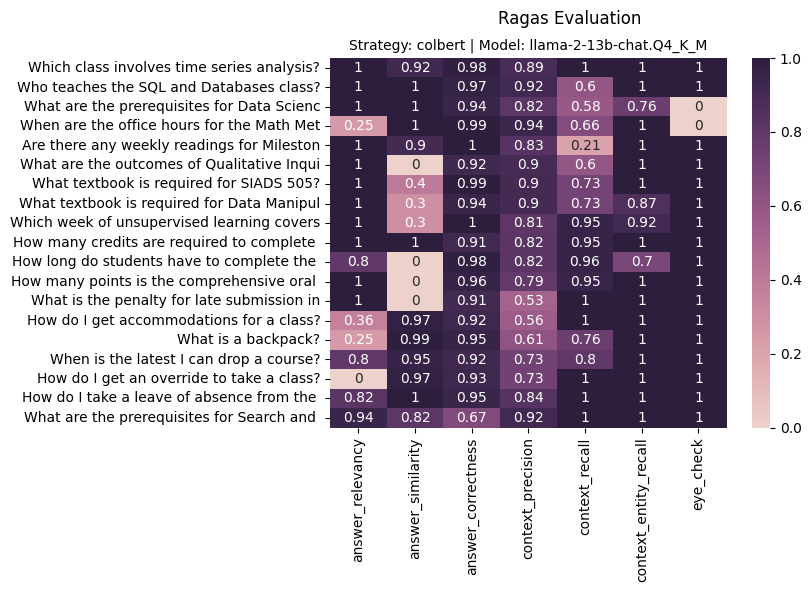

In [16]:
sns.heatmap(
    results_df[
        [
            "answer_relevancy",
            "answer_similarity",
            "answer_correctness",
            "context_precision",
            "context_recall",
            "context_entity_recall",
            "eye_check",
        ]
    ],
    yticklabels=results_df["question"].str[:42],
    annot=True,
    cmap=sns.cubehelix_palette(as_cmap=True),
)

plt.suptitle("Ragas Evaluation")
plt.title(f"Strategy: {retrieval_strategy} | Model: {model}", fontsize=10)

plt.show()